In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [11]:
front_2Dcoord = np.load('front_image.npy', allow_pickle=True)
back_2Dcoord = np.load('back_image.npy', allow_pickle=True)
front_img = cv2.imread('front.png')


(12, 2) (12, 2)


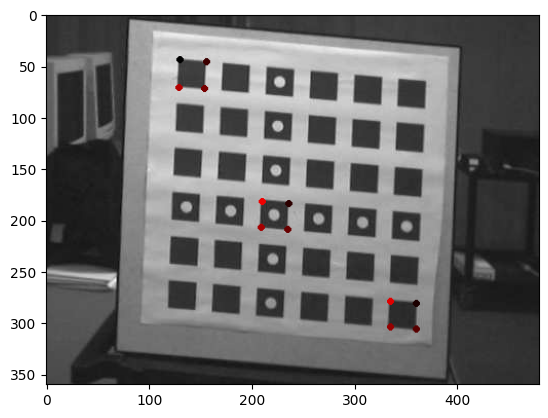

In [12]:
#visualization
print(front_2Dcoord.shape, back_2Dcoord.shape)
from copy import deepcopy
vis_img = deepcopy(front_img)
for i in range(front_2Dcoord.shape[0]):
    cv2.circle(vis_img, (int(front_2Dcoord[i,0]), int(front_2Dcoord[i,1])), 2, (0,0,(60*i)%256), 2)
plt.imshow(vis_img[:,:,::-1])
plt.show()

In [13]:
# ------------TODO----------------
# Compute corresponding 3D coordinate
# ------------TODO----------------
front_3Dcoord = np.zeros((12, 3))
back_3Dcoord = np.zeros((12, 3))

front_grid = np.array([[0,0,0],[50,0,0],[50,50,0],[0,50,0]])
back_grid = np.array([[0,0,150],[50,0,150],[50,50,150],[0,50,150]])
for i in range(4):
    front_3Dcoord[i] = front_grid[i]
    back_3Dcoord[i] = back_grid[i]
    front_3Dcoord[i+4] = front_grid[i] + np.array([160,240,0])
    back_3Dcoord[i+4] = back_grid[i] + np.array([160,240,0])
    front_3Dcoord[i+8] = front_grid[i] + np.array([400,400,0])
    back_3Dcoord[i+8] = back_grid[i] + np.array([400,400,0])



all_2Dcoord = np.concatenate((front_2Dcoord, back_2Dcoord), axis=0)
all_3Dcoord = np.concatenate((front_3Dcoord, back_3Dcoord), axis=0)
print(all_2Dcoord.shape, all_3Dcoord.shape)

(24, 2) (24, 3)


In [14]:
# ------------TODO----------------
# Construct the Equation Pm=0 and solve m
# ------------TODO----------------

P = np.zeros((48, 12))

zero_vec = np.zeros(4)

# construct the homogeneous equation
for i in range(24): # iterate over all 24 3D-2D correspondences
    p_i = np.concatenate([all_3Dcoord[i], [1]]) # homogeneous 3D coord
    P[2*i] = np.concatenate([p_i, zero_vec, -all_2Dcoord[i,0]*p_i])
    P[2*i + 1] = np.concatenate([zero_vec, p_i, -all_2Dcoord[i,1]*p_i])

_, _, V = np.linalg.svd(P)
m = V[-1]

In [15]:
# ------------TODO----------------
# Solve K, and [R T] from m
# ------------TODO----------------

M = m.reshape((3,4)) # norm = 1
A = M[:, :3]
b = M[:, 3]


# intrinsic
a_1, a_2, a_3 = A[0], A[1], A[2]
rho = 1 / np.linalg.norm(a_3)
c_x = (rho ** 2) * (a_1 @ a_3) 
c_y = (rho ** 2) * (a_2 @ a_3) 

unnorm_cos = np.cross(a_2, a_3) @ np.cross(a_3, a_1)
theta = np.arccos(unnorm_cos / (np.linalg.norm(np.cross(a_2, a_3)) * np.linalg.norm(np.cross(a_3, a_1))) )

alpha = (rho ** 2) * np.linalg.norm(np.cross(a_1, a_3)) * np.sin(theta)
beta = (rho ** 2) * np.linalg.norm(np.cross(a_2, a_3)) * np.sin(theta)

K = np.array([[alpha, -alpha * np.cos(theta) / np.sin(theta), c_x],
                [0, beta / np.sin(theta), c_y],
                [0, 0, 1]])

# extrinsic
r_1 = np.cross(a_2, a_3) / np.linalg.norm(np.cross(a_2, a_3))
r_3 = a_3 / np.linalg.norm(a_3)
r_2 = np.cross(r_3, r_1)
R = np.array((r_1, r_2, r_3))

T = rho * np.linalg.inv(K) @ b
print(T)



[383001.83680588 -67357.81783291  67071.11331876]


In [16]:
# save results
save_dict = {'3Dcoord': all_3Dcoord, 'P':P, 'm':m, 'K':K, 'R':R, 'T':T}
np.save('../results/calibr', save_dict)

# The reference answer of T should be [383001.8386981  -67357.81794783  67071.11338303]
# The results are very strange because the data is fake.